In [ ]:
# !mkdir /content/test
# !bash /content/test/a.sh WaterRamps /content/test
# import tensorflow as tf

# filenames = '/content/temp/datasets/WaterDrop/test.tfrecord'
# raw_dataset = tf.data.TFRecordDataset(filenames)
# for raw_record in raw_dataset.take(2):
#   # example = tf.train.Example()
#   # example.ParseFromString(raw_record.numpy())
#   print(raw_record)

# Simulating Complex Physics with Graph Networks

In [ ]:
import os
import torch
print(f"PyTorch has version {torch.__version__} with cuda {torch.version.cuda}")

PyTorch has version 2.0.0+cu118 with cuda 11.8


In [ ]:
# Install torch geometric
!pip install torch-scatter -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-geometric

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-2.0.0+cu118.html
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-2.0.0+cu118.html
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-2.0.0+cu118.html
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import urllib.request
import tqdm as tqdm1
from tqdm.notebook import tqdm
class TqdmUpTo(tqdm):
    def update_to(self, b=1, bsize=1, tsize=None):
        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)

def download_with_progress(url, output_file):
    with TqdmUpTo(unit='B', unit_scale=True, miniters=1, desc=url.split('/')[-1]) as t:
        urllib.request.urlretrieve(url, output_file, reporthook=t.update_to)

DATASET_NAME = "WaterDrop"
OUTPUT_DIR = os.path.join("temp", "datasets", DATASET_NAME)

BASE_URL=f"https://storage.googleapis.com/learning-to-simulate-complex-physics/Datasets/{DATASET_NAME}/"

!mkdir -p "$OUTPUT_DIR"

files_to_download = ['metadata.json', 'train.tfrecord', 'valid.tfrecord', 'test.tfrecord']
if not os.path.isfile('/content/temp/datasets/WaterDrop/test.tfrecord'):
  for file in files_to_download:
      output_file = os.path.join(OUTPUT_DIR, file)
      url = f"{BASE_URL}{file}"
      download_with_progress(url, output_file)

In [ ]:
import json
import numpy as np
import torch_geometric as pyg

def generate_noise(position_seq, noise_std):
    """Generate noise for a trajectory"""
    velocity_seq = position_seq[:, 1:] - position_seq[:, :-1]
    time_steps = velocity_seq.size(1)
    velocity_noise = torch.randn_like(velocity_seq) * (noise_std / time_steps ** 0.5)
    velocity_noise = velocity_noise.cumsum(dim=1)
    position_noise = velocity_noise.cumsum(dim=1)
    position_noise = torch.cat((torch.zeros_like(position_noise)[:, 0:1], position_noise), dim=1)
    return position_noise


def preprocess(particle_type, position_seq, target_position, metadata, noise_std):
    """Preprocess a trajectory and construct the graph"""
    # apply noise to the trajectory
    position_noise = generate_noise(position_seq, noise_std)
    position_seq = position_seq + position_noise

    # calculate the velocities of particles
    recent_position = position_seq[:, -1]
    velocity_seq = position_seq[:, 1:] - position_seq[:, :-1]

    # construct the graph based on the distances between particles
    n_particle = recent_position.size(0)
    edge_index = pyg.nn.radius_graph(recent_position, metadata["default_connectivity_radius"], loop=True, max_num_neighbors=n_particle)
    
    # node-level features: velocity, distance to the boundary
    normal_velocity_seq = (velocity_seq - torch.tensor(metadata["vel_mean"])) / torch.sqrt(torch.tensor(metadata["vel_std"]) ** 2 + noise_std ** 2)
    boundary = torch.tensor(metadata["bounds"])
    distance_to_lower_boundary = recent_position - boundary[:, 0]
    distance_to_upper_boundary = boundary[:, 1] - recent_position
    distance_to_boundary = torch.cat((distance_to_lower_boundary, distance_to_upper_boundary), dim=-1)
    distance_to_boundary = torch.clip(distance_to_boundary / metadata["default_connectivity_radius"], -1.0, 1.0)

    # edge-level features: displacement, distance
    dim = recent_position.size(-1)
    edge_displacement = (torch.gather(recent_position, dim=0, index=edge_index[0].unsqueeze(-1).expand(-1, dim)) -
                   torch.gather(recent_position, dim=0, index=edge_index[1].unsqueeze(-1).expand(-1, dim)))
    edge_displacement /= metadata["default_connectivity_radius"]
    edge_distance = torch.norm(edge_displacement, dim=-1, keepdim=True)

    # ground truth for training
    if target_position is not None:
        last_velocity = velocity_seq[:, -1]
        next_velocity = target_position + position_noise[:, -1] - recent_position
        acceleration = next_velocity - last_velocity
        acceleration = (acceleration - torch.tensor(metadata["acc_mean"])) / torch.sqrt(torch.tensor(metadata["acc_std"]) ** 2 + noise_std ** 2)
    else:
        acceleration = None

    # return the graph with features
    graph = pyg.data.Data(
        x=particle_type,
        edge_index=edge_index,
        edge_attr=torch.cat((edge_displacement, edge_distance), dim=-1),
        y=acceleration,
        pos=torch.cat((normal_velocity_seq.reshape(normal_velocity_seq.size(0), -1), distance_to_boundary), dim=-1)
    )
    return graph

In [ ]:
import functools
import numpy as np
import tensorflow.compat.v1 as tf

# Create a description of the features.
_FEATURE_DESCRIPTION = {
    'position': tf.io.VarLenFeature(tf.string),
}

_FEATURE_DESCRIPTION_WITH_GLOBAL_CONTEXT = _FEATURE_DESCRIPTION.copy()
_FEATURE_DESCRIPTION_WITH_GLOBAL_CONTEXT['step_context'] = tf.io.VarLenFeature(
    tf.string)

_FEATURE_DTYPES = {
    'position': {
        'in': np.float32,
        'out': tf.float32
    },
    'step_context': {
        'in': np.float32,
        'out': tf.float32
    }
}

_CONTEXT_FEATURES = {
    'key': tf.io.FixedLenFeature([], tf.int64, default_value=0),
    'particle_type': tf.io.VarLenFeature(tf.string)
}


def convert_to_tensor(x, encoded_dtype):
  if len(x) == 1:
    out = np.frombuffer(x[0].numpy(), dtype=encoded_dtype)
  else:
    out = []
    for el in x:
      out.append(np.frombuffer(el.numpy(), dtype=encoded_dtype))
  out = tf.convert_to_tensor(np.array(out))
  return out

def parse_serialized_simulation_example(example_proto, metadata):
  """Parses a serialized simulation tf.SequenceExample.
  Args:
    example_proto: A string encoding of the tf.SequenceExample proto.
    metadata: A dict of metadata for the dataset.
  Returns:
    context: A dict, with features that do not vary over the trajectory.
    parsed_features: A dict of tf.Tensors representing the parsed examples
      across time, where axis zero is the time axis.
  """
  if 'context_mean' in metadata:
    feature_description = _FEATURE_DESCRIPTION_WITH_GLOBAL_CONTEXT
  else:
    feature_description = _FEATURE_DESCRIPTION
  context, parsed_features = tf.io.parse_single_sequence_example(
      example_proto,
      context_features=_CONTEXT_FEATURES,
      sequence_features=feature_description)
  for feature_key, item in parsed_features.items():
    convert_fn = functools.partial(
        convert_to_tensor, encoded_dtype=_FEATURE_DTYPES[feature_key]['in'])
    parsed_features[feature_key] = tf.py_function(
        convert_fn, inp=[item.values], Tout=_FEATURE_DTYPES[feature_key]['out'])

  # There is an extra frame at the beginning so we can calculate pos change
  # for all frames used in the paper.
  position_shape = [-1, metadata['sequence_length'] + 1, metadata['dim']]

  # Reshape positions to correct dim:
  parsed_features['position'] = tf.reshape(parsed_features['position'],
                                           position_shape)
  # Set correct shapes of the remaining tensors.
  sequence_length = metadata['sequence_length'] + 1
  if 'context_mean' in metadata:
    context_feat_len = len(metadata['context_mean'])
    parsed_features['step_context'] = tf.reshape(
        parsed_features['step_context'],
        [sequence_length, context_feat_len])
  # Decode particle type explicitly
  context['particle_type'] = tf.py_function(
      functools.partial(convert_fn, encoded_dtype=np.int64),
      inp=[context['particle_type'].values],
      Tout=[tf.int64])
  context['particle_type'] = tf.reshape(context['particle_type'], [-1])
  return context, parsed_features

In [ ]:
data_path = f'/content/temp/datasets/{DATASET_NAME}'
def _read_metadata(data_path):
  with open(os.path.join(data_path, 'metadata.json'), 'rt') as fp:
    return json.loads(fp.read())
metadata = _read_metadata(data_path)
# for context, features in ds:
#     print(features['position'].shape)
if not os.path.isfile('/content/temp/datasets/WaterDrop/train_position.dat'):
  for split in ['train','valid','test']:
    # Create a tf.data.Dataset from the TFRecord.
    ds = tf.data.TFRecordDataset([os.path.join(data_path, f'{split}.tfrecord')])
    ds = ds.map(functools.partial(
          parse_serialized_simulation_example, metadata=metadata))
    particle_type_list = []
    position_list = []
    offsets = {}
    key = 0
    offset_particle_type = 0
    offset_position = 0
    for context, features in tqdm(ds):
      # if split == 'train' and key == 100:
      #   break
        particle_type_list.append(context['particle_type'].numpy())
        position_list.append(features['position'].numpy())
        offsets[key] = {}
        offsets[key]['particle_type'] = {'offset': offset_particle_type}
        offsets[key]['position'] = {'offset': int(offset_position), 'shape': np.transpose(features['position'].numpy(), (1, 0, 2)).shape}
        key += 1
        # print('len(context[particle_type].numpy())',len(context['particle_type'].numpy()))
        offset_particle_type += len(context['particle_type'].numpy())
        # offset_position += len(features['position'].numpy())
        offset_position += np.prod(features['position'].numpy().shape)
    # 将 particle_type 合并成一个 ndarray，并保存到文件中
    particle_type_array = np.concatenate(particle_type_list)
    position_array = np.concatenate(position_list, axis=0)

    with open(f"/content/temp/datasets/{DATASET_NAME}/{split}_particle_type.dat", "wb") as f:
        particle_type_array.tofile(f)
    with open(f"/content/temp/datasets/{DATASET_NAME}/{split}_position.dat", "wb") as f:
        position_array.tofile(f)
    with open(f'/content/temp/datasets/{DATASET_NAME}/{split}_offset.json', 'w') as f:
        json.dump(offsets, f)

In [ ]:
class OneStepDataset(pyg.data.Dataset):
    def __init__(self, data_path, split, window_length=7, noise_std=0.0, return_pos=False):
        super().__init__()

        # load dataset from the disk
        with open(os.path.join(data_path, "metadata.json")) as f:
            self.metadata = json.load(f)
        with open(os.path.join(data_path, f"{split}_offset.json")) as f:
            self.offset = json.load(f)

        self.offset = {int(k): v for k, v in self.offset.items()}
        self.window_length = window_length
        self.noise_std = noise_std
        self.return_pos = return_pos

        self.particle_type = np.memmap(os.path.join(data_path, f"{split}_particle_type.dat"), dtype=np.int64, mode="r")
        self.position = np.memmap(os.path.join(data_path, f"{split}_position.dat"), dtype=np.float32, mode="r")
        print('self.position.shape',self.position.shape)

        for traj in self.offset.values():
            self.dim = traj["position"]["shape"][2]
            break

        # cut particle trajectories according to time slices
        self.windows = []
        for traj in self.offset.values():
            size = traj["position"]["shape"][1]
            length = traj["position"]["shape"][0] - window_length + 1
            for i in range(length):
                desc = {
                    "size": size,
                    "type": traj["particle_type"]["offset"],
                    "pos": traj["position"]["offset"] + i * size * self.dim,
                }
                self.windows.append(desc)

    def len(self):
        return len(self.windows)

    def get(self, idx):
        # load corresponding data for this time slice
        window = self.windows[idx]
        size = window["size"]
        particle_type = self.particle_type[window["type"]: window["type"] + size].copy()
        particle_type = torch.from_numpy(particle_type)
        position_seq = self.position[window["pos"]: window["pos"] + self.window_length * size * self.dim].copy()
        position_seq.resize(self.window_length, size, self.dim)
        position_seq = position_seq.transpose(1, 0, 2)
        target_position = position_seq[:, -1]
        position_seq = position_seq[:, :-1]
        target_position = torch.from_numpy(target_position)
        position_seq = torch.from_numpy(position_seq)
        
        # construct the graph
        with torch.no_grad():
            graph = preprocess(particle_type, position_seq, target_position, self.metadata, self.noise_std)
        if self.return_pos:
          return graph, position_seq[:, -1]
        return graph

In [ ]:
class RolloutDataset(pyg.data.Dataset):
    def __init__(self, data_path, split, window_length=7):
        super().__init__()
        
        # load data from the disk
        with open(os.path.join(data_path, "metadata.json")) as f:
            self.metadata = json.load(f)
        with open(os.path.join(data_path, f"{split}_offset.json")) as f:
            self.offset = json.load(f)
        self.offset = {int(k): v for k, v in self.offset.items()}
        self.window_length = window_length

        self.particle_type = np.memmap(os.path.join(data_path, f"{split}_particle_type.dat"), dtype=np.int64, mode="r")
        self.position = np.memmap(os.path.join(data_path, f"{split}_position.dat"), dtype=np.float32, mode="r")

        for traj in self.offset.values():
            self.dim = traj["position"]["shape"][2]
            break

    def len(self):
        return len(self.offset)

    def get(self, idx):
        traj = self.offset[idx]
        size = traj["position"]["shape"][1]
        time_step = traj["position"]["shape"][0]
        particle_type = self.particle_type[traj["particle_type"]["offset"]: traj["particle_type"]["offset"] + size].copy()
        particle_type = torch.from_numpy(particle_type)
        position = self.position[traj["position"]["offset"]: traj["position"]["offset"] + time_step * size * self.dim].copy()
        position.resize(traj["position"]["shape"])
        position = torch.from_numpy(position)
        data = {"particle_type": particle_type, "position": position}
        return data

self.position.shape (34120086,)
The first item in the valid set is a graph: Data(x=[482], edge_index=[2, 3070], edge_attr=[3070, 3], y=[482, 2], pos=[482, 14])
This graph has 482 nodes and 3070 edges.
Each node is a particle and each edge is the interaction between two particles.
Each node has 1 categorial feature (Data.x), which represents the type of the node.
Each node has a 14-dim feature vector (Data.pos), which represents the positions and velocities of the particle (node) in several frames.
Each edge has a 3-dim feature vector (Data.edge_attr), which represents the relative distance and displacement between particles.
The model is expected to predict a 2-dim vector for each node (Data.y), which represents the acceleration of the particle.


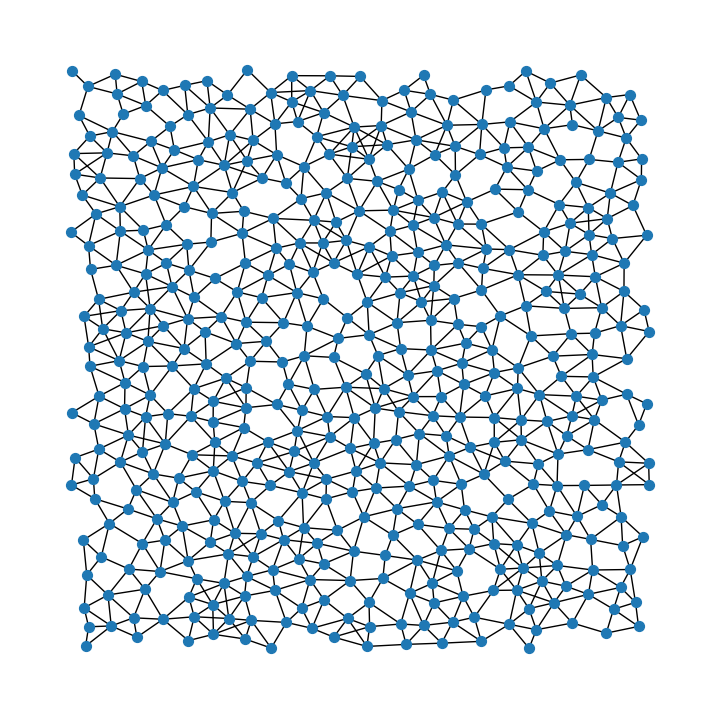

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import networkx as nx

dataset_sample = OneStepDataset(OUTPUT_DIR, "valid", return_pos=True)
graph, position = dataset_sample[0]

print(f"The first item in the valid set is a graph: {graph}")
print(f"This graph has {graph.num_nodes} nodes and {graph.num_edges} edges.")
print(f"Each node is a particle and each edge is the interaction between two particles.")
print(f"Each node has {graph.num_node_features} categorial feature (Data.x), which represents the type of the node.")
print(f"Each node has a {graph.pos.size(1)}-dim feature vector (Data.pos), which represents the positions and velocities of the particle (node) in several frames.")
print(f"Each edge has a {graph.num_edge_features}-dim feature vector (Data.edge_attr), which represents the relative distance and displacement between particles.")
print(f"The model is expected to predict a {graph.y.size(1)}-dim vector for each node (Data.y), which represents the acceleration of the particle.")

# remove directions of edges, because it is a symmetric directed graph.
nx_graph = pyg.utils.to_networkx(graph).to_undirected()
# remove self loops, because every node has a self loop.
nx_graph.remove_edges_from(nx.selfloop_edges(nx_graph))
plt.figure(figsize=(7, 7))
nx.draw(nx_graph, pos={i: tuple(v) for i, v in enumerate(position)}, node_size=50)
plt.show()

In [ ]:
import math
import torch_scatter

class MLP(torch.nn.Module):
    """Multi-Layer perceptron"""
    def __init__(self, input_size, hidden_size, output_size, layers, layernorm=True):
        super().__init__()
        self.layers = torch.nn.ModuleList()
        for i in range(layers):
            self.layers.append(torch.nn.Linear(
                input_size if i == 0 else hidden_size,
                output_size if i == layers - 1 else hidden_size,
            ))
            if i != layers - 1:
                self.layers.append(torch.nn.ReLU())
        if layernorm:
            self.layers.append(torch.nn.LayerNorm(output_size))
        self.reset_parameters()

    def reset_parameters(self):
        for layer in self.layers:
            if isinstance(layer, torch.nn.Linear):
                layer.weight.data.normal_(0, 1 / math.sqrt(layer.in_features))
                layer.bias.data.fill_(0)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

In [ ]:
class InteractionNetwork(pyg.nn.MessagePassing):
    """Interaction Network as proposed in this paper: 
    https://proceedings.neurips.cc/paper/2016/hash/3147da8ab4a0437c15ef51a5cc7f2dc4-Abstract.html"""
    def __init__(self, hidden_size, layers):
        super().__init__()
        # self.flag = 0
        self.lin_edge = MLP(hidden_size * 3, hidden_size, hidden_size, layers)
        self.lin_node = MLP(hidden_size * 2, hidden_size, hidden_size, layers)
        self.edge_update_layer = MLP(hidden_size * 3, hidden_size, hidden_size, layers)
    def forward(self, x, edge_index, edge_feature):
        # self.flag = 0
        edge_out, aggr = self.propagate(edge_index, x=(x, x), edge_feature=edge_feature)
        node_out = self.lin_node(torch.cat((x, aggr), dim=-1))
        node_out = x + node_out
        # self.flag = 1
        # edge_out, _ = self.propagate(edge_index, x=(node_out, node_out), edge_feature=edge_feature)
        edge_out = edge_feature + edge_out
        return node_out, edge_out

    def message(self, x_i, x_j, edge_feature):
        # if self.flag == 0:
        x = torch.cat((x_i, x_j, edge_feature), dim=-1)
        x = self.lin_edge(x)
        return x
        # if self.flag == 1:
        #   x = torch.cat((x_i, x_j, edge_feature), dim=-1)
        #   x = self.edge_update_layer(x)
        #   return x

    def aggregate(self, inputs, index, dim_size=None):
        out = torch_scatter.scatter(inputs, index, dim=self.node_dim, dim_size=dim_size, reduce="sum")
        return (inputs, out)

In [ ]:
class LearnedSimulator(torch.nn.Module):
    """Graph Network-based Simulators(GNS)"""
    def __init__(
        self,
        hidden_size=128,
        n_mp_layers=20, # number of GNN layers
        num_particle_types=9,
        particle_type_dim=16, # embedding dimension of particle types
        dim=2, # dimension of the world, typical 2D or 3D
        window_size=5, # the model looks into W frames before the frame to be predicted
    ):
        super().__init__()
        self.window_size = window_size
        self.embed_type = torch.nn.Embedding(num_particle_types, particle_type_dim)
        self.node_in = MLP(particle_type_dim + dim * (window_size + 2), hidden_size, hidden_size, 3)
        self.edge_in = MLP(dim + 1, hidden_size, hidden_size, 3)
        self.node_out = MLP(hidden_size, hidden_size, dim, 3, layernorm=False)
        self.n_mp_layers = n_mp_layers
        self.layers = torch.nn.ModuleList([InteractionNetwork(
            hidden_size, 3
        ) for _ in range(n_mp_layers)])

        self.reset_parameters()

    def reset_parameters(self):
        torch.nn.init.xavier_uniform_(self.embed_type.weight)

    def forward(self, data):
        # pre-processing
        # node feature: combine categorial feature data.x and contiguous feature data.pos.
        node_feature = torch.cat((self.embed_type(data.x), data.pos), dim=-1)
        node_feature = self.node_in(node_feature)
        edge_feature = self.edge_in(data.edge_attr)
        # stack of GNN layers
        for i in range(self.n_mp_layers):
            node_feature, edge_feature = self.layers[i](node_feature, data.edge_index, edge_feature=edge_feature)
        # post-processing
        out = self.node_out(node_feature)
        return out

In [ ]:
data_path = OUTPUT_DIR
model_path = os.path.join("temp", "models", DATASET_NAME)
rollout_path = os.path.join("temp", "rollouts", DATASET_NAME)

!mkdir -p "$model_path"
!mkdir -p "$rollout_path"

params = {
    "epoch": 1,
    "batch_size": 16,
    "lr": 8e-4,
    "noise": 3e-4,
    "save_interval": 15000,
    "eval_interval": 15000,
    "rollout_interval": 15000,
}

In [ ]:
def rollout(model, data, metadata, noise_std):
    device = next(model.parameters()).device
    model.eval()
    window_size = model.window_size + 1
    total_time = data["position"].size(0)
    traj = data["position"][:window_size]
    traj = traj.permute(1, 0, 2)
    particle_type = data["particle_type"]

    for time in range(total_time - window_size):
        with torch.no_grad():
            graph = preprocess(particle_type, traj[:, -window_size:], None, metadata, 0.0)
            graph = graph.to(device)
            acceleration = model(graph).cpu()
            acceleration = acceleration * torch.sqrt(torch.tensor(metadata["acc_std"]) ** 2 + noise_std ** 2) + torch.tensor(metadata["acc_mean"])

            recent_position = traj[:, -1]
            recent_velocity = recent_position - traj[:, -2]
            new_velocity = recent_velocity + acceleration
            new_position = recent_position + new_velocity
            traj = torch.cat((traj, new_position.unsqueeze(1)), dim=1)

    return traj

def oneStepMSE(simulator, dataloader, metadata, noise):
    """Returns two values, loss and MSE"""
    total_loss = 0.0
    total_mse = 0.0
    batch_count = 0
    simulator.eval()
    with torch.no_grad():
        scale = torch.sqrt(torch.tensor(metadata["acc_std"]) ** 2 + noise ** 2).cuda()
        for data in tqdm(dataloader, position=0):
            data = data.cuda()
            pred = simulator(data)
            mse = ((pred - data.y) * scale) ** 2
            mse = mse.sum(dim=-1).mean()
            loss = ((pred - data.y) ** 2).mean()
            total_mse += mse.item()
            total_loss += loss.item()
            batch_count += 1
    return total_loss / batch_count, total_mse / batch_count

def rolloutMSE(simulator, dataset, noise):
    total_loss = 0.0
    batch_count = 0
    simulator.eval()
    with torch.no_grad():
        for rollout_data in tqdm(dataset, position=0):
            rollout_out = rollout(simulator, rollout_data, dataset.metadata, noise)
            rollout_out = rollout_out.permute(1, 0, 2)
            loss = (rollout_out - rollout_data["position"]) ** 2
            loss = loss.sum(dim=-1).mean()
            total_loss += loss.item()
            batch_count += 1
    return total_loss / batch_count


Here is the main training loop!

In [ ]:


def train(params, simulator, train_loader, valid_loader, valid_rollout_dataset):
    loss_fn = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(simulator.parameters(), lr=params["lr"])
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.1 ** (8 / 2.5e5))

    # recording loss curve
    train_loss_list_average = []
    train_loss_list = []
    eval_loss_list = []
    onestep_mse_list = []
    rollout_mse_list = []
    total_step = 0

    for i in range(params["epoch"]):
        simulator.train()
        progress_bar = tqdm1.tqdm(train_loader, desc=f"Epoch {i}")
        total_loss = 0
        batch_count = 0
        for data in progress_bar:
            optimizer.zero_grad()
            data = data.cuda()
            pred = simulator(data)
            loss = loss_fn(pred, data.y)
            loss.backward()
            optimizer.step()
            scheduler.step()
            total_loss += loss.item()
            batch_count += 1
            progress_bar.set_postfix({"loss": loss.item(), "avg_loss": total_loss / batch_count, "lr": optimizer.param_groups[0]["lr"]})
            total_step += 1
            train_loss_list.append((total_step, loss.item()))
            train_loss_list_average.append((total_step, total_loss / batch_count))

            # evaluation
            if total_step % params["eval_interval"] == 0:
                simulator.eval()
                eval_loss, onestep_mse = oneStepMSE(simulator, valid_loader, valid_dataset.metadata, params["noise"])
                eval_loss_list.append((total_step, eval_loss))
                onestep_mse_list.append((total_step, onestep_mse))
                tqdm.write(f"\nEval: Loss: {eval_loss}, One Step MSE: {onestep_mse}")
                simulator.train()

            # do rollout on valid set
            if total_step % params["rollout_interval"] == 0:
                simulator.eval()
                rollout_mse = rolloutMSE(simulator, valid_rollout_dataset, params["noise"])
                rollout_mse_list.append((total_step, rollout_mse))
                tqdm.write(f"\nEval: Rollout MSE: {rollout_mse}")
                simulator.train()

            # save model
            if total_step % params["save_interval"] == 0:
                torch.save(
                    {
                        "model": simulator.state_dict(),
                        "optimizer": optimizer.state_dict(),
                        "scheduler": scheduler.state_dict(),
                    },
                    os.path.join(model_path, f"checkpoint_{total_step}.pt")
                )
    torch.save(
                    {
                        "model": simulator.state_dict(),
                        "optimizer": optimizer.state_dict(),
                        "scheduler": scheduler.state_dict(),
                    },
                    os.path.join(model_path, f"checkpoint_{total_step}.pt")
                )
    return train_loss_list, eval_loss_list, onestep_mse_list, rollout_mse_list, train_loss_list_average

In [ ]:
# load dataset
train_dataset = OneStepDataset(data_path, "train", noise_std=params["noise"])
valid_dataset = OneStepDataset(data_path, "valid", noise_std=params["noise"])
train_loader = pyg.loader.DataLoader(train_dataset, batch_size=params["batch_size"], shuffle=True, pin_memory=True, num_workers=2)
valid_loader = pyg.loader.DataLoader(valid_dataset, batch_size=params["batch_size"], shuffle=False, pin_memory=True, num_workers=2)
valid_rollout_dataset = RolloutDataset(data_path, "valid")

# build model
simulator = LearnedSimulator()
simulator = simulator.cuda()

# train the model
train_loss_list, eval_loss_list, onestep_mse_list, rollout_mse_list, train_loss_list_average = train(params, simulator, train_loader, valid_loader, valid_rollout_dataset)

self.position.shape (1129402274,)
self.position.shape (34120086,)


Epoch 0:   0%|          | 0/62188 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/torch_geometric/data/collate.py:145: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel)
/usr/local/lib/python3.9/dist-packages/torch_geometric/data/collate.py:145: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel)
Epoch 0:  24%|██▍       | 14999/62188 [1:54:27<5:54:54,  2.22it/s, loss=0.0428, avg_loss=0.096, lr=0.000265]

  0%|          | 0/1866 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/torch_geometric/data/collate.py:145: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel)
/usr/local/lib/python3.9/dist-packages/torch_geometric/data/collate.py:145: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel)
Epoch 0:  24%|██▍       | 14999/62188 [2:00:37<5:54:54,  2.22it/s, loss=0.0428, avg_loss=0.096, lr=0.000265]


Eval: Loss: 0.04434776793823988, One Step MSE: 8.445807174267117e-09


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 0:  24%|██▍       | 14999/62188 [2:11:17<5:54:54,  2.22it/s, loss=0.0428, avg_loss=0.096, lr=0.000265]


Eval: Rollout MSE: 0.04283141891161601


Epoch 0:  48%|████▊     | 29999/62188 [4:05:37<3:59:27,  2.24it/s, loss=0.0202, avg_loss=0.0669, lr=8.77e-5]

  0%|          | 0/1866 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/torch_geometric/data/collate.py:145: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel)
/usr/local/lib/python3.9/dist-packages/torch_geometric/data/collate.py:145: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel)
Epoch 0:  48%|████▊     | 29999/62188 [4:11:46<3:59:27,  2.24it/s, loss=0.0202, avg_loss=0.0669, lr=8.77e-5]


Eval: Loss: 0.02955723051351095, One Step MSE: 5.627609012531138e-09


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 0:  48%|████▊     | 30000/62188 [4:22:05<2656:17:43, 297.09s/it, loss=0.0202, avg_loss=0.0669, lr=8.77e-5]


Eval: Rollout MSE: 0.021459593779097


Epoch 0:  72%|███████▏  | 44999/62188 [6:16:26<2:12:10,  2.17it/s, loss=0.0245, avg_loss=0.0541, lr=2.9e-5]

  0%|          | 0/1866 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/torch_geometric/data/collate.py:145: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel)
/usr/local/lib/python3.9/dist-packages/torch_geometric/data/collate.py:145: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel)
Epoch 0:  72%|███████▏  | 44999/62188 [6:22:36<2:12:10,  2.17it/s, loss=0.0245, avg_loss=0.0541, lr=2.9e-5]


Eval: Loss: 0.02552832982483912, One Step MSE: 4.8606611313006575e-09


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 0:  72%|███████▏  | 45000/62188 [6:32:59<1423:58:59, 298.25s/it, loss=0.0245, avg_loss=0.0541, lr=2.9e-5]


Eval: Rollout MSE: 0.018820985763644178


Epoch 0:  96%|█████████▋| 59999/62188 [8:27:34<16:37,  2.19it/s, loss=0.0179, avg_loss=0.047, lr=9.62e-6]

  0%|          | 0/1866 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/torch_geometric/data/collate.py:145: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel)
/usr/local/lib/python3.9/dist-packages/torch_geometric/data/collate.py:145: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel)
Epoch 0:  96%|█████████▋| 59999/62188 [8:33:43<16:37,  2.19it/s, loss=0.0179, avg_loss=0.047, lr=9.62e-6]


Eval: Loss: 0.02422343605868758, One Step MSE: 4.611598644160468e-09


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 0:  96%|█████████▋| 60000/62188 [8:43:48<178:00:29, 292.88s/it, loss=0.0179, avg_loss=0.047, lr=9.62e-6]


Eval: Rollout MSE: 0.01665053457642595


Epoch 0: 100%|██████████| 62188/62188 [9:00:29<00:00,  1.92it/s, loss=0.0214, avg_loss=0.0463, lr=8.19e-6]


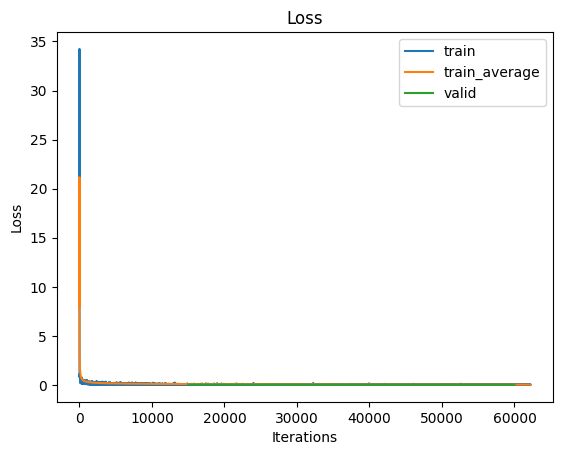

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

# visualize the loss curve
plt.figure()
plt.plot(*zip(*train_loss_list), label="train")
plt.plot(*zip(*train_loss_list_average), label="train_average")
plt.plot(*zip(*eval_loss_list), label="valid")
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()
plt.show()

In [ ]:
# simulator = LearnedSimulator()
# simulator = simulator.cuda()
# checkpoint = torch.load("/content/temp/models/WaterDrop/checkpoint_60000.pt")
# simulator.load_state_dict(checkpoint["model"])

<All keys matched successfully>

In [ ]:
rollout_dataset = RolloutDataset(data_path, "valid")
simulator.eval()
rollout_data = rollout_dataset[0]
rollout_out = rollout(simulator, rollout_data, rollout_dataset.metadata, 0)
rollout_out = rollout_out.permute(1, 0, 2)

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

TYPE_TO_COLOR = {
    3: "black",
    0: "green",
    7: "magenta",
    6: "gold",
    5: "blue",
}


def visualize_prepare(ax, particle_type, position, metadata):
    bounds = metadata["bounds"]
    ax.set_xlim(bounds[0][0], bounds[0][1])
    ax.set_ylim(bounds[1][0], bounds[1][1])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect(1.0)
    points = {type_: ax.plot([], [], "o", ms=2, color=color)[0] for type_, color in TYPE_TO_COLOR.items()}
    return ax, position, points


def visualize_pair(particle_type, position_pred, position_gt, metadata):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    plot_info = [
        visualize_prepare(axes[0], particle_type, position_gt, metadata),
        visualize_prepare(axes[1], particle_type, position_pred, metadata),
    ]
    axes[0].set_title("Ground truth")
    axes[1].set_title("Prediction")

    plt.close()

    def update(step_i):
        outputs = []
        for _, position, points in plot_info:
            for type_, line in points.items():
                mask = particle_type == type_
                line.set_data(position[step_i, mask, 0], position[step_i, mask, 1])
            outputs.append(line)
        return outputs

    return animation.FuncAnimation(fig, update, frames=np.arange(0, position_gt.size(0)), interval=10, blit=True)

anim = visualize_pair(rollout_data["particle_type"], rollout_out, rollout_data["position"], rollout_dataset.metadata)
HTML(anim.to_html5_video())

In [ ]:
!nvidia-smi

Sat Apr  8 21:47:01 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P0    28W /  70W |  10257MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------